In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

# 1 - Load Fashion MNIST by Pandas, exactly the same procedure as in Logistic Regression

In [4]:
TRAIN_FILE = '../fashionmnist/fashion-mnist_train.csv'
TEST_FILE = '../fashionmnist/fashion-mnist_test.csv'
train_data = pd.read_csv(TRAIN_FILE)
test_data = pd.read_csv(TEST_FILE)
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_train_all = np.array(train_data.iloc[:, 1:])
print('pixel value max=', np.max(X_train_all))
X_train_all = X_train_all/ 255
m_train_all = X_train_all.shape[0]
num_px = X_train_all.shape[1]
num_class = 10
y_train_all = np.array(train_data.iloc[:, 0], dtype = 'uint8').reshape(-1,1)
print('total number of training examples =', m_train_all, ', number of pixels =', num_px)

pixel value max= 255
total number of training examples = 60000 , number of pixels = 784


In [6]:
#To speed up calculation, only 5000 out of 60000 examples will be used as training set
#Although the original data are already random, still shuffle them for general purpose
m_train = 5000
np.random.seed( 3 )
permutation = list(np.random.permutation(m_train_all))
shuffled_X = X_train_all[permutation, :]
shuffled_y = y_train_all[permutation,:]
X_train = shuffled_X[0:m_train,:].T
y_train = shuffled_y[0:m_train,:].T
print('X_train shape', X_train.shape, 'y_train shape', y_train.shape)
print('number of training examples used:', X_train.shape[1])

X_train shape (784, 5000) y_train shape (1, 5000)
number of training examples used: 5000


In [7]:
X_test = np.array(test_data.iloc[:, 1:])
y_test = np.array(test_data.iloc[:, 0], dtype = 'uint8').reshape(-1,1)
X_test = X_test.T
y_test = y_test.T
print('X_test shape:', X_test.shape, 'y_test shape:', y_test.shape)

X_test shape: (784, 10000) y_test shape: (1, 10000)


# 2 - Neural Networks 

### He initialization

In [8]:
layers_dims = [X_train.shape[0], 50, 20, num_class]
#l=0 is always called 'init', just correspond to X
# In this problem, L = 3, l=0 just X, l=1,2 Relu, l=3 softmax
activations = ['init','Relu','Relu','softmax']

def initialize_parameters_he(layers_dims):    
    np.random.seed(3)
    paras = {}
    L = len(layers_dims) - 1 # integer representing the number of layers

    for l in range(1, L + 1):
        paras['W' + str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1]) * np.sqrt(2/layers_dims[l-1])
        paras['b' + str(l)] = np.zeros((layers_dims[l],1))
        
    return paras

### Activation functions and derivatives

In [9]:
def soft_max(Z):
    # substract Z by max(Z) to avoid numerical blowing up
    # although usually each number of Z shouldn't be too big
    Z -= np.max(Z,axis=0)
    A = np.exp(Z)
    norm_A = np.sum(A, axis = 0, keepdims = True)
    softmax = A/norm_A
    return softmax

def Relu(Z):
    res = np.maximum(0, Z)
    return res

def Relu_backward(Z):
    Z[Z>0] = 1
    Z[Z<=0] = 0
    return Z

### Forward propagation

In [10]:
def linear_activation_forward(Wl, bl, Alminus1, activation):
    Zl = np.dot(Wl, Alminus1) + bl
    if activation == 'Relu':
        Al = Relu(Zl)
    elif activation == 'softmax':
        Al = soft_max(Zl)     
    cache = (Zl, Alminus1)
    return Al, cache

def forward_propagation(paras, X, activations):
    L = len(paras)//2
    #initialize at l=0, cache at l = 0 is never used, assigning values to keep index   
    #store (Zl, Al-1) for each l, they're going to be used in backward propagation
    caches = [(0,0)]
    #A0 = X
    Alminus1 = X
    for l in range(1,L+1):
        #print('A'+str(l-1)+' dimension = ', Alminus1.shape)
        activation = activations[l]
        Al, cache = linear_activation_forward(paras['W'+str(l)], paras['b'+str(l)], Alminus1, activation)
        caches.append(cache)
        
        #update A for next step
        Alminus1 = Al
        #print('A'+str(l)+' dimension = ', Al.shape)
    AL = Al
    return AL, caches

### Cost function with regularization

In [11]:
def regularization(paras, lambd, m):
    L = len(paras)//2
    reg = 0
    for l in range(1,L+1):
        Wl = paras['W' + str(l)]
        reg += np.sum(Wl*Wl)
    reg *= lambd/2/m 
    return reg
                

def compute_cost_softmax_reg(AL, y, paras, lambd):
    m = y.shape[1]
    L = len(paras)//2    
    reg = regularization(paras, lambd, m)
    cost = -1/m * np.sum(np.log(AL[y, range(m)]),axis = 1)
    cost += reg
    cost = np.squeeze(cost)
    return cost

### Backward propagation

In [12]:
def cost_one_layer_backward(y, AL, cache, para, activation, lambd):
    WL = para
    (ZL, ALminus1) = cache
    m = y.shape[1]
    if activation == 'softmax':
        dZL = AL   
        dZL[y, range(m)] -= 1    
    
    dWL = 1/m* np.dot(dZL, ALminus1.T)
    dWL += lambd/m * WL    
    dbL = 1/m * np.sum(dZL, axis=1, keepdims = True)
     
    return dZL, dWL, dbL


def one_layer_backward(dZlplus1, cache, para, activation, lambd):
    (Wlplus1, Wl) = para
    (Zl, Alminus1) = cache
    if activation == 'Relu':
        dZl = np.dot(Wlplus1.T, dZlplus1) * Relu_backward(Zl)
        
    m = dZl.shape[1]        
    dWl = 1/m* np.dot(dZl, Alminus1.T)
    dWl += lambd/m * Wl    
    dbl = 1/m * np.sum(dZl, axis=1, keepdims = True)
     
    return dZl, dWl, dbl

def backward_propagation(y, AL, paras, caches, activations, lambd):
    L = len(paras)//2
    grads = {}
    
    for l in reversed(range(1, L+1)):
        cache = caches[l]
        activation = activations[l]
        if l ==  L:
            para = paras['W'+str(l)]
            dZl, dWl, dbl = cost_one_layer_backward(y, AL, cache, para, activation, lambd)
        else:
            para = (paras['W'+str(l+1)],paras['W'+str(l)])
            dZl, dWl, dbl = one_layer_backward(dZl, cache, para, activation, lambd)
        
        grads['dW'+str(l)] = dWl
        grads['db'+str(l)] = dbl
            
    return grads

def update_paras_with_gd(paras,grads, learning_rate):
    L = len(paras)//2
    new_paras = {}
    for l in range(1,L+1):
        Wl = paras['W'+str(l)]
        bl = paras['b'+str(l)]
        dWl = grads['dW'+str(l)]
        dbl = grads['db'+str(l)]
        Wl = Wl - learning_rate * dWl
        bl = bl - learning_rate * dbl    
        new_paras['W'+str(l)] = Wl
        new_paras['b'+str(l)] = bl
    return new_paras

### Cost optimization and predict function

In [13]:
def optimize(paras, X, y, lambd, num_iter, learning_rate):
    costs = []
    for i in range(num_iter):
        AL, caches = forward_propagation(paras, X, activations)
        cost = compute_cost_softmax_reg(AL, y, paras, lambd)
        grads = backward_propagation(y, AL, paras, caches, activations, lambd)

        paras = update_paras_with_gd(paras, grads, learning_rate)
        
        costs.append(cost)

    return costs, paras

def predict_accuracy(paras, X, y,activations):
    L = len(paras)//2
    #A0 = X
    Al = X
    for l in range(1,L+1):
        activation = activations[l]
        Al, _ = linear_activation_forward(paras['W'+str(l)], paras['b'+str(l)], Al, activation)

    AL = Al    
    
    predicted_class = np.argmax(AL, axis=0)
    accuracy = np.mean(predicted_class == y)
    return accuracy

### Running the batch

learning rate = 1.0E-01
train accuracy: 0.881
test accuracy: 0.751
---------------------
learning rate = 5.0E-02
train accuracy: 0.871
test accuracy: 0.764
---------------------
learning rate = 1.0E-02
train accuracy: 0.814
test accuracy: 0.756
---------------------


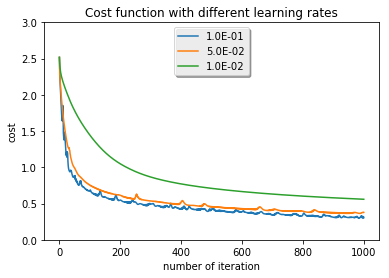

In [16]:
learning_rates = [1e-1, 5*1e-2, 1e-2]
lambd = 0.01
for rate in learning_rates:
    paras = initialize_parameters_he(layers_dims)
    costs, paras = optimize(paras, X_train, y_train, lambd, num_iter = 1000, learning_rate = rate)
    plt.plot(np.squeeze(costs), label = '%.1E' %rate)
    
    print('learning rate = %.1E' %rate)
    accuracy = predict_accuracy(paras, X_train, y_train,activations)
    print('train accuracy: %.3f' %accuracy)
    accuracy = predict_accuracy(paras, X_test, y_test,activations)
    print('test accuracy: %.3f' %accuracy)
    print('---------------------')

plt.ylabel('cost')
plt.xlabel('number of iteration')
plt.title("Cost function with different learning rates" )
legend = plt.legend(loc='upper center', shadow=True)
axes = plt.gca()
axes.set_ylim([0,3])
plt.show()